In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib
from scipy import integrate 
from simple_dispatch import bidStack
from simple_dispatch import GridModel
import matplotlib.transforms as transforms
import warnings
import datetime
warnings.simplefilter(action='ignore', category=FutureWarning)
colorset = ['#882255','#88CCEE','#332288', '#DDCC77',   '#CC6677','#44AA99', '#117733','#AA4499','#999933']

# Figure S1 

In [2]:
def plotBidStackMultiColor4(self, df_column, ax=None, xlim=86, save_str=None, show_legend=True, show_fig=True, xlab=False):    
    
    # adapted from Thomas Deetjen's code : https://github.com/tdeetjen/simple_dispatch
    bs_df_fuel_color = self.df.copy()
    
    # Add column "fuel_color" to dataframe based on fuel type for each generator
    legend_mapping = {'sub_st':'Subbituminous Coal', 'ng_ct':'Natural Gas Combined Cycle', 
                      'ng_gt':'Natural Gas Combustion Turbine', 'ng_st':'Natural Gas Boiler', 
                      'rc_st':'Refined Coal', 'bit_st':'Bituminous Coal', '_':'Other'}
    c = {'ng': {'cc': colorset[0], 'ct': colorset[1], 'gt': colorset[2], 'st': colorset[3]}, 'sub': {'st': colorset[4]}, 'lig': {'st': str(colorset[5])}, 'bit': {'st': colorset[6]}, 'rc': {'st':  colorset[7]}}
    bs_df_fuel_color['fuel_color'] = '#bcbddc'
    for c_key in c.keys():
        for p_key in c[c_key].keys():
            bs_df_fuel_color.loc[(bs_df_fuel_color.fuel == c_key) & (bs_df_fuel_color.prime_mover == p_key), 'fuel_color'] = c[c_key][p_key]
        empty_color = '#dd1c77'
        color_2 = bs_df_fuel_color.fuel_color.replace('', empty_color)
        
    # prepare y depending on whether plotting cost or emissions
    y_data_e = self.df.gen_cost * 0
    if df_column == 'gen_cost':
        y_lab = 'Generation Cost [$/MWh]'
        y_data = self.df[df_column] - (self.df.co2_cost + self.df.so2_cost + self.df.nox_cost) #cost excluding emissions taxes
    if df_column == 'co2':
        y_lab = 'CO$_2$ Emissions [kg/MWh]'
        y_data = self.df[df_column + str(self.time)]

    # plot
    if ax is None:
        f, ax = matplotlib.pyplot.subplots(figsize=(4, 4))
    # Bar chart: width of each is the capacity. Shift position by one indice so that the bar lines up to the left of its capacity. E.g. if the first one has capacity 10, the bar goes from 0 to 10 and the following bar starts from 10. 
    ax.bar((self.df['mw' + str(self.time)].cumsum()[:-1])/1000, height=y_data.values[1:], width=(self.df['mw' + str(self.time)].values[1:])/1000, color=color_2.values[1:], align='edge')
    if show_legend:
        color_legend = []
        for c in bs_df_fuel_color.fuel_color.unique():# colorset:#['#e41a1c', '#ff7f00', '#252525', '#377eb8', '#4daf4a', '#984ea3', '#bcbddc']:#bs_df_fuel_color.fuel_color.unique():
            color_legend.append(matplotlib.patches.Patch(color=c, label=legend_mapping[bs_df_fuel_color.fuel[bs_df_fuel_color.fuel_color==c].iloc[0] + '_' + bs_df_fuel_color.prime_mover[bs_df_fuel_color.fuel_color==c].iloc[0]]))
        ax.legend(handles=color_legend, loc='upper left', ncol=1, fontsize=12)
    ax.set_xlim(0, xlim)
    if df_column == 'gen_cost':
        ax.set_ylim(0, 90)
        ax.set_yticks((0, 15, 30, 45, 60, 75, 90, 105))
        ax.set_yticklabels((0, 15, 30, 45, 60, 75, 90, 105), fontsize=14)
        ax.set_yticklabels((0, 15, 30, 45, 60, 75, 90, 105), fontsize=18)
    elif df_column == 'co2':
        ax.set_ylim(0, 1400)
        ax.set_yticks((250, 500, 750, 1000, 1250))
        ax.set_yticklabels((250, 500, 750, 1000, 1250), fontsize=14)
        ax.set_yticklabels((250, 500, 750, 1000, 1250), fontsize=18)
    if xlab:
        ax.set_xlabel('Generation Capacity [GW]', fontsize=14)
        ax.set_xlabel('Generation Capacity [GW]', fontsize=18)
        ax.set_xticklabels((0, 10, 20, 30, 40, 50, 60, 70, 80, 90), fontsize=14)
        ax.set_xticklabels((0, 10, 20, 30, 40, 50, 60, 70, 80, 90), fontsize=18)
    else:
        ax.set_xticklabels([])
    ax.set_xticks((0, 10, 20, 30, 40, 50, 60, 70, 80, 90))
    ax.set_ylabel(y_lab, fontsize=14)
    #ax.set_ylabel(y_lab, fontsize=18)
    
    ax.set_axisbelow(True)        
    ax.grid()

    plt.tight_layout()
    if save_str is not None:
        plt.savefig(save_str, bbox_inches='tight')
    if show_fig:
        plt.show()
    
    return ax

In [3]:
gds = {}
gds[2019] = pickle.load(open('Data/generator_data_short_WECC_2019.obj', 'rb'))
gds[2020] = pickle.load(open('Data/generator_data_short_WECC_2020.obj', 'rb'))

C:\Users\sonia\AppData\Local\Temp\ipykernel_28328\1369742855.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels((0, 10, 20, 30, 40, 50, 60, 70, 80, 90), fontsize=14)
C:\Users\sonia\AppData\Local\Temp\ipykernel_28328\1369742855.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels((0, 10, 20, 30, 40, 50, 60, 70, 80, 90), fontsize=18)


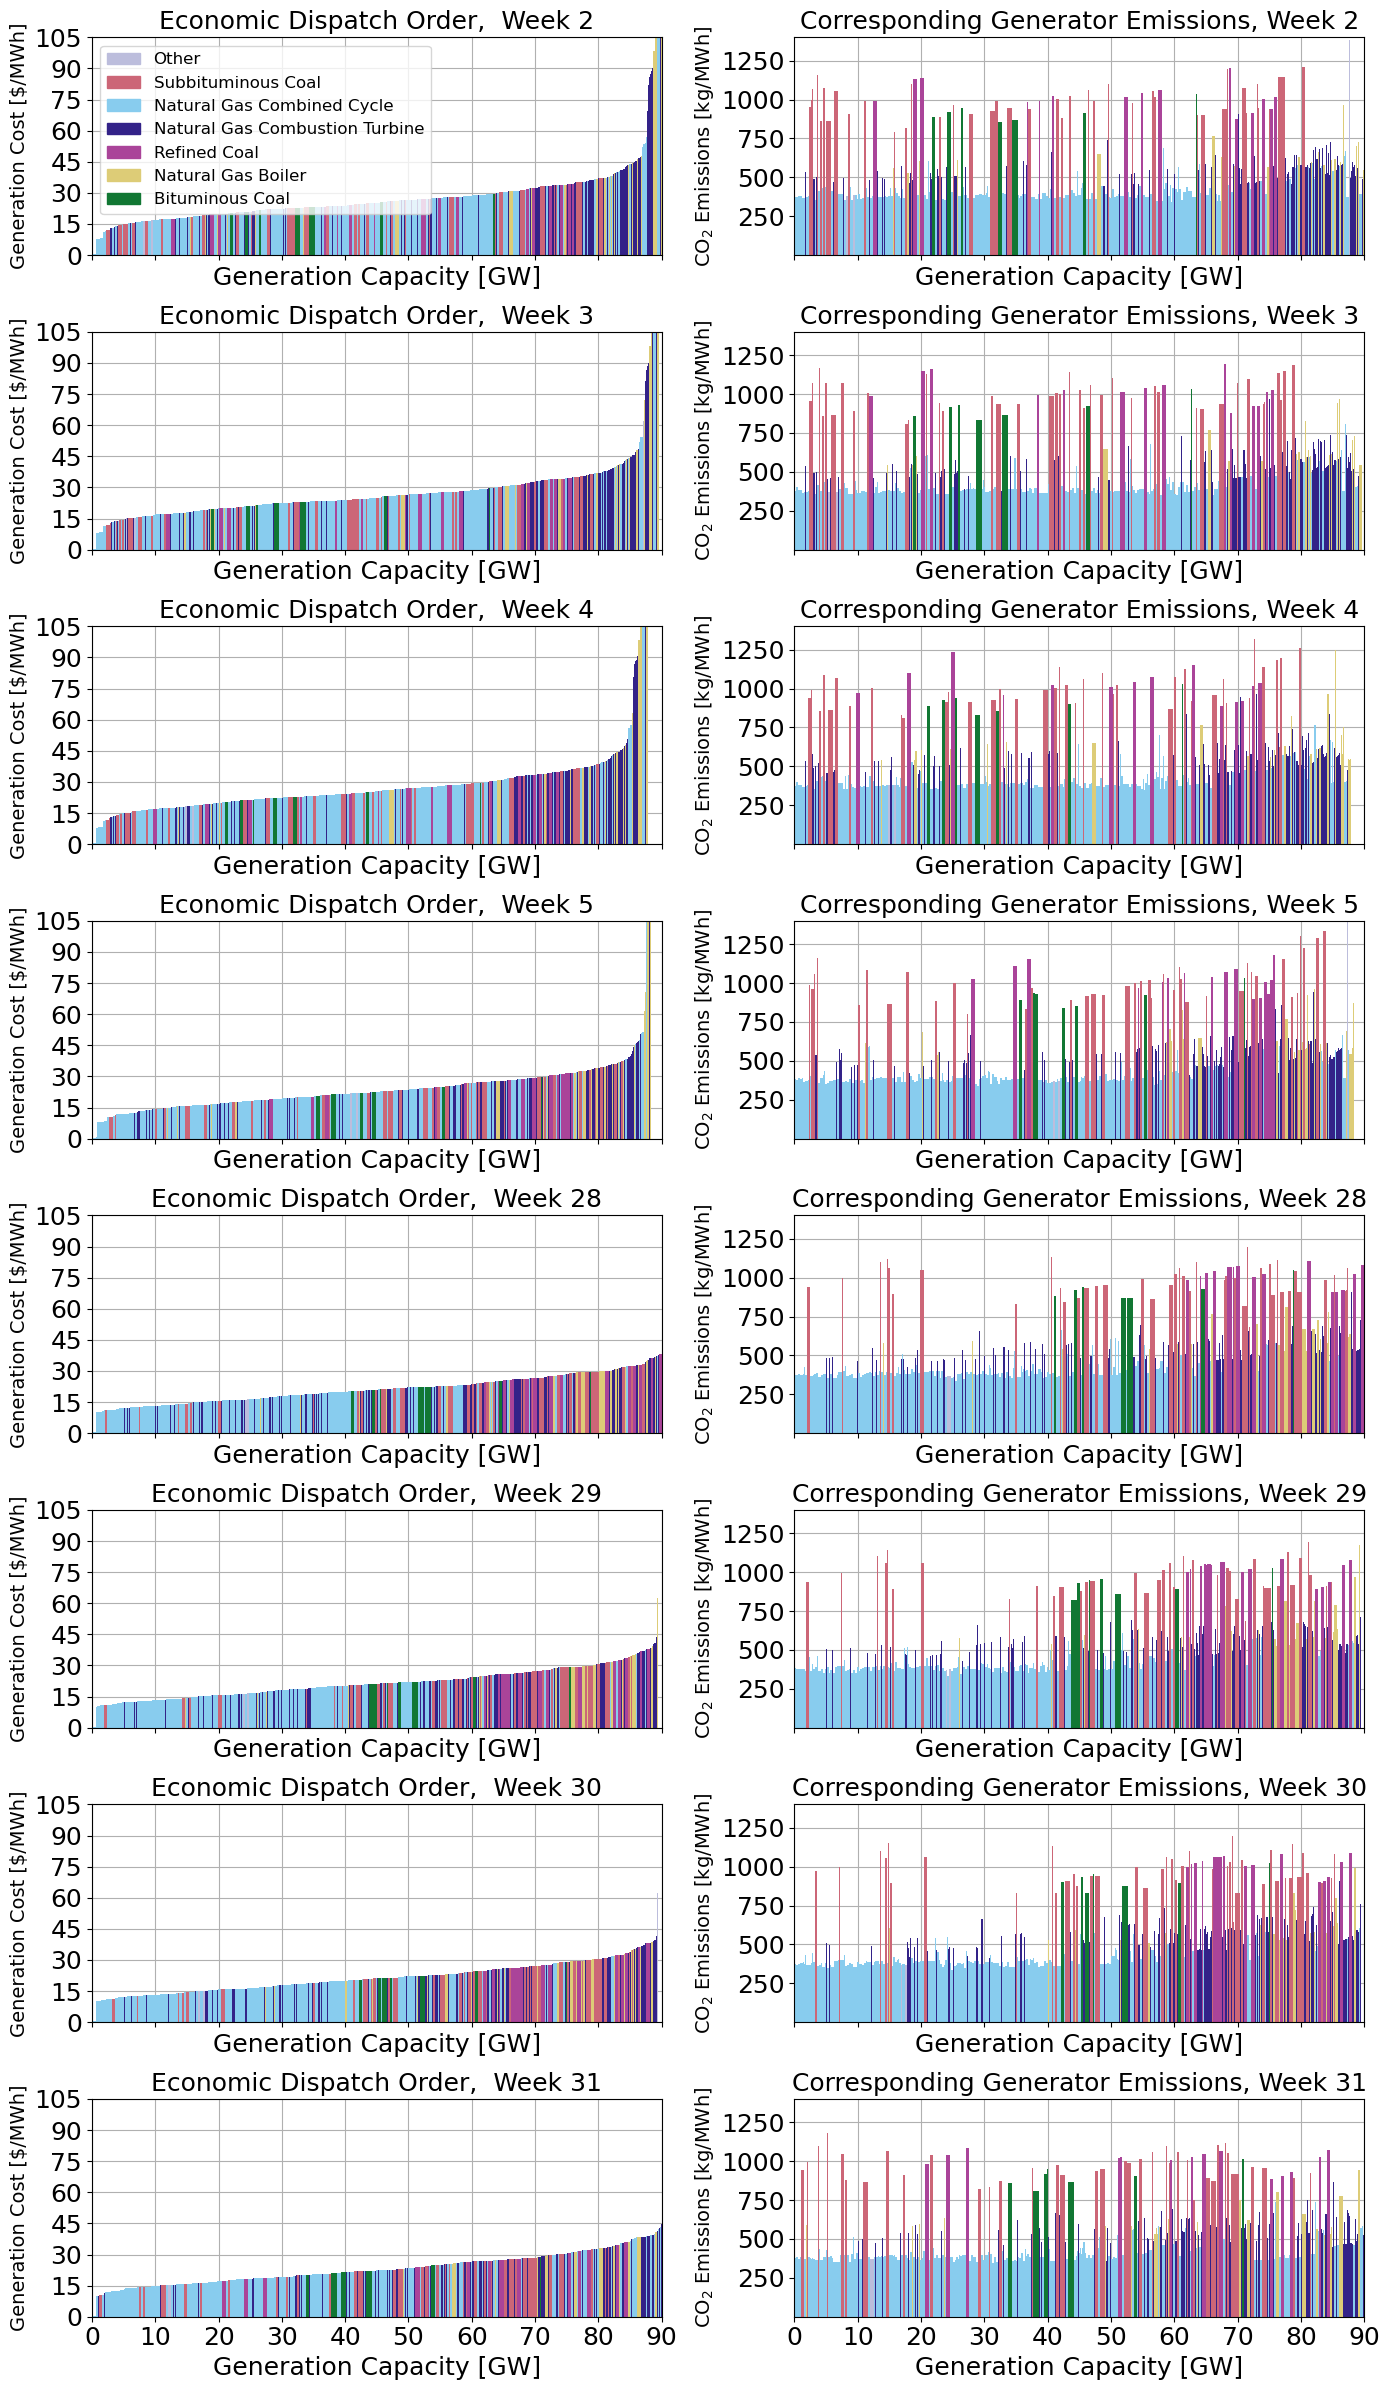

In [4]:
#merit order variability visualization
xlim = 90#86

weeks = [2,3,4,5,28,29,30,31] #January and July week numbers
f, axes = plt.subplots(len(weeks), 2, figsize=(14,24), sharex=True)

plt.subplots_adjust(hspace=0.4)
for i, week in  enumerate(weeks):
    bs = bidStack(gds[2020], co2_dol_per_kg=0, time=week, dropNucHydroGeo=True, include_min_output=False, mdt_weight=0.5, include_easiur=False) 
    axes[i,0].set_title('Economic Dispatch Order,  Week '+str(week), fontsize=18)
    axes[i,1].set_title('Corresponding Generator Emissions, Week '+str(week), fontsize=18)
    if i==0:
        axes[i,0] = plotBidStackMultiColor4(bs, 'gen_cost', ax=axes[i,0], show_legend=True, show_fig=False, xlab=True, xlim=xlim)
    else:
        axes[i,0] = plotBidStackMultiColor4(bs, 'gen_cost', ax=axes[i,0], show_legend=False, show_fig=False, xlab=True, xlim=xlim)
    
    axes[i,1] = plotBidStackMultiColor4(bs, 'co2', ax=axes[i,1], show_legend=False, show_fig=False, xlim=xlim, xlab=True, 
                                    save_str='Merit_Order/S1a_merit_variability.pdf')
    